,PVA_COUNT_OF_EACH_DRUG_FAMILY,NAME_OF_NDC,Total Count of NDC,Percentage of NON_PVA of NDC
0,0,"""HELIXATE FS 1,000 UNIT VIAL""",1,100.00
1,39,OXYCODONE-ACETAMINOPHEN 10-325,5942,99.34
2,168,ELIQUIS 5 MG TABLET,2762,93.92
3,9,NORCO 10-325 TABLET,145,93.79
4,183,ADVAIR 250-50 DISKUS,2585,92.92
5,289,PROVENTIL HFA 90 MCG INHALER,2860,89.90
6,258,LYRICA 75 MG CAPSULE,2416,89.32
7,246,BUPRENORPHIN-NALOXON 8-2 MG SL,2301,89.31


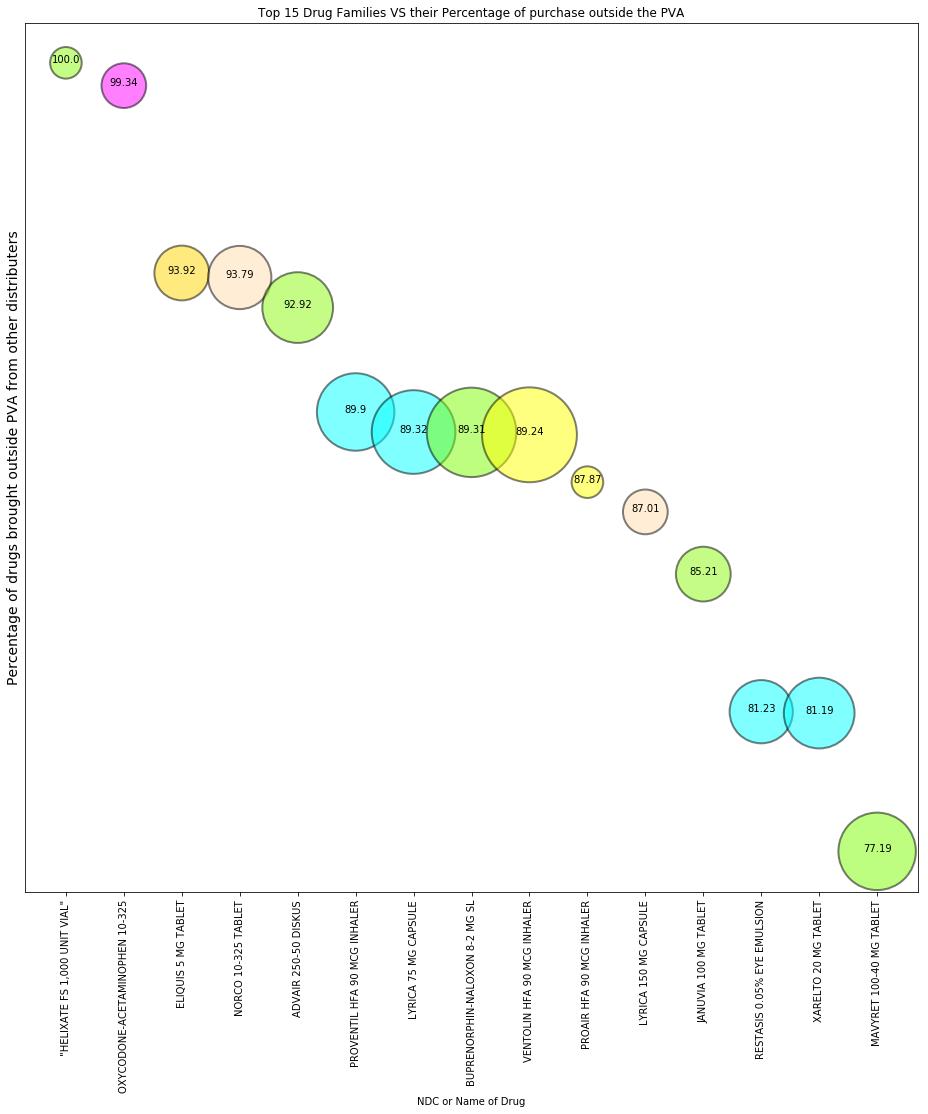

In [265]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display,display_html
from operator import itemgetter
from sklearn.ensemble import RandomForestClassifier
rf= RandomForestClassifier(criterion='entropy',n_estimators=10,random_state=0)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
lbl=LabelEncoder()
df= pd.read_csv('AIS datasheet.csv')
listOfNamesOfNDC=['PHRMCY_NAME','BUY_GRP_NAM','NDC_DESC','DSPN_QTY_NDC_1WK','PURCH_QTY_NDC_1WK_MTRC','DSPN_QTY_NDC_4WKS','PURCH_QTY_NDC_4WKS_MTRC','DSPN_QTY_NDC_13WKS','PURCH_QTY_NDC_13WKS_MTRC','DSPN_QTY_NDC_26WKS','PURCH_QTY_NDC_26WKS_MTRC','DSPN_QTY_GCN_1WK','PURCH_QTY_GCN_1WK_MTRC','DSPN_QTY_GCN_4WKS','PURCH_QTY_GCN_4WKS_MTRC','DSPN_QTY_GCN_13WKS','PURCH_QTY_GCN_13WKS_MTRC','DSPN_QTY_GCN_26WKS','PURCH_QTY_GCN_26WKS_MTRC']
df1= df[listOfNamesOfNDC]
Xdf1=df1.iloc[:,2:20].values
Xdf1[:,0] = lbl.fit_transform(Xdf1[:,0])
Y1=[]
dictFinal=dict()
dictNew=dict()
index=0
dfNew=df1['NDC_DESC'].drop_duplicates(inplace=False)
for each in dfNew:
    dictNew[index] = each
    index+=1
k=0
totalCount=pd.DataFrame()
while k < index:
    listN=[]
    for each in df1.values:
        if each[2] == dictNew[k]:
            listN.append(each)
    a= np.array(listN)
    e=pd.DataFrame(a,columns=listOfNamesOfNDC)
    X= e.iloc[:,2:20]
    isPVA=0
    for i in range(0,X.shape[0]):
        count=0
        temp= X.iloc[i,:].values
        for i in range(1,len(temp),2):
            if abs(temp[i]-temp[i+1]) >50:
                count+=1
        if count ==0:
            Y1.append('PVA')
            isPVA+=1
        else:
            Y1.append('NON_PVA')
    dictFinal[isPVA] = dictNew[k]
    k+=1
a=sorted(dictFinal.items(),key= itemgetter(0),reverse=True)
#print('aaa: ',a)
keys=pd.DataFrame()
values=pd.DataFrame()
dtCombined=pd.DataFrame()
Ydf1 = np.array(Y1)
rf.fit(Xdf1,Ydf1)
totalCount = pd.DataFrame(df['NDC_DESC'].value_counts())
totalCount.reset_index(drop=False,inplace=True)
totalCount.columns= ['NAME_OF_NDC','Total Count of NDC']
#display(totalCount)
for each in a:
    keys = pd.concat([keys,pd.DataFrame([each[0]])],axis=0)
    values = pd.concat([values,pd.DataFrame([each[1]])],axis=0)
table_Feature_Importance=pd.DataFrame(rf.feature_importances_,index=df1.iloc[:,2:20].columns,columns=['importances']).sort_values('importances',ascending=False)
#display(table_Feature_Importance)
dtCombined=pd.concat([keys,values],axis=1)
dtCombined.columns=['PVA_COUNT_OF_EACH_DRUG_FAMILY','NAME_OF_NDC']
#display(dtCombined)
dtMerged = pd.merge(dtCombined,totalCount, on='NAME_OF_NDC',how='inner')
dtMerged['Percentage of NON_PVA of NDC'] = round((((dtMerged['Total Count of NDC']-dtMerged['PVA_COUNT_OF_EACH_DRUG_FAMILY'])/dtMerged['Total Count of NDC']) * 100),2)
dtMerged = dtMerged.sort_values(by='Percentage of NON_PVA of NDC',ascending=False).reset_index(drop=True)
display(dtMerged[0:8])
color=np.arange(1,10,1)
ax = plt.figure(figsize=(16,16))

ax=plt.scatter(x=dtMerged['NAME_OF_NDC'][0:15],y=dtMerged['Percentage of NON_PVA of NDC'][0:15],
            c=['#8BFA0D','#FF00FF','#FFD700','#FFDEAD','#8BFA0D','#00FFFF','#00FFFF',
             '#7CFC00','#FFFF00','#FFFF00','#FFDEAD','#8BFA0D','#00FFFF','#00FFFF',
             '#7CFC00'],s=color*1000,alpha=0.50,edgecolors='black',linewidth=2)
#plt.legend(loc='best')
plt.tick_params(labelleft=False,left=False)
plt.xticks(rotation=90)
#plt.box(False)
plt.ylabel('Percentage of drugs brought outside PVA from other distributers',fontsize=14 )
plt.xlabel('NDC or Name of Drug')
plt.title('Top 15 Drug Families VS their Percentage of purchase outside the PVA')
for i, value in enumerate(dtMerged['Percentage of NON_PVA of NDC'][0:15]):
    #plt.text(i-0.15,value,str(value),color='Black',fontsize=10)
    plt.annotate(str(value),xy=(i,value),ha='center')
plt.show()
#plt.pie([keys[0],keys[1],keys[2],keys[3],keys[4]],labels=[values[0],values[1],values[2],values[3],values[4]],autopct='%.2f',explode=(0.06,0.06,0.06,0.06,0.06))
#plt.show()

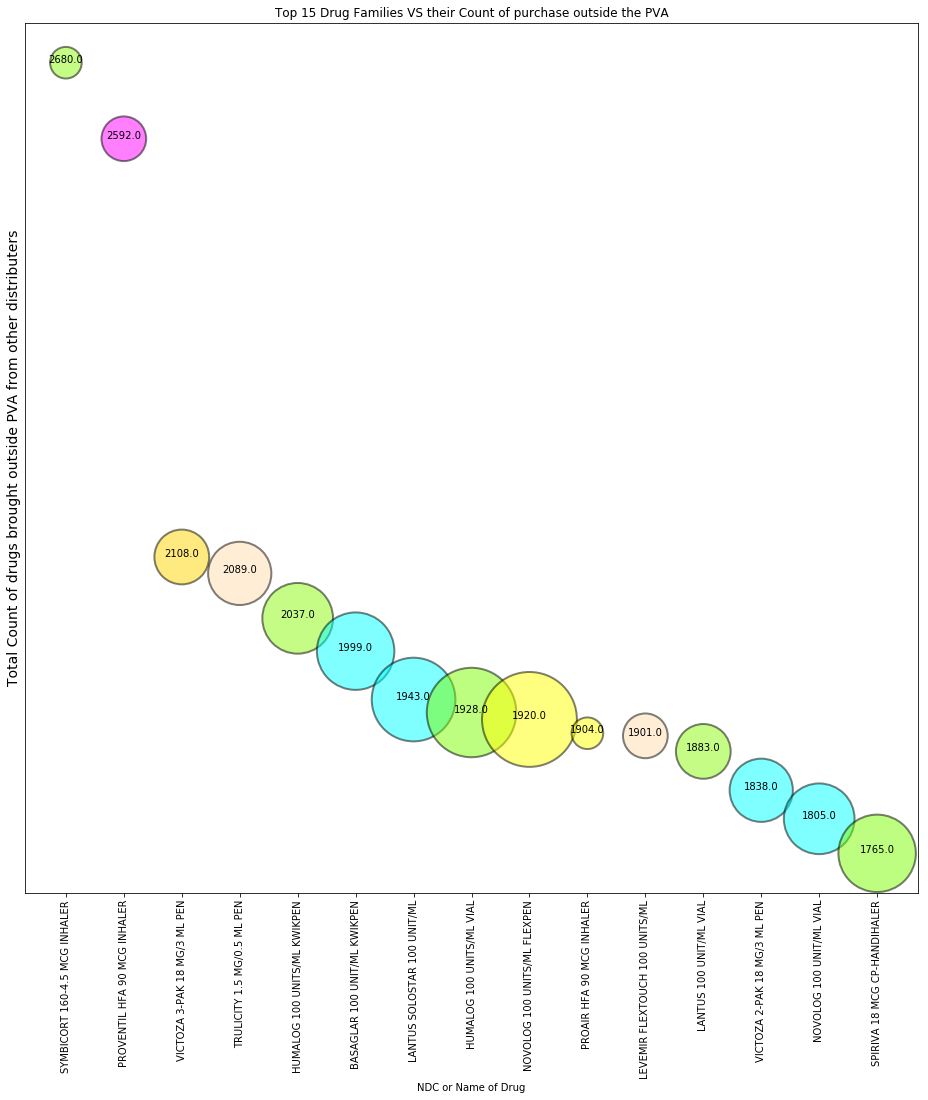

In [303]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
df=pd.read_csv('AIS datasheet.csv')
df.head(2)
from IPython.display import display

def func(value):
    pvaSeries=pd.Series()
    
    value['newValue'] =(value[['DSPN-PURCHASE_1WK','DSPN-PURCHASE_4WKS','DSPN-PURCHASE_13WKS','DSPN-PURCHASE_26WKS']].sum(axis=1))/4
    pvaSeries = pvaSeries.append(pd.Series(['Yes' if each < 50  else 'No'  for each in value['newValue']]))
    PVAStatus = pd.concat([pd.DataFrame(value['NDC_DESC'].unique()),pd.DataFrame(pvaSeries.value_counts()).transpose()],axis=1)
    #display(PVAStatus)
    return(PVAStatus)

def func1():
    overAllPVA=pd.DataFrame() 
    for key,value in df.groupby('NDC_DESC'):
        PVAstatus= pd.Series()

        end=['PHRMCY_NAME','BUY_GRP_NAM','NDC_DESC','DSPN_QTY_NDC_1WK','PURCH_QTY_NDC_1WK_MTRC','DSPN_QTY_NDC_4WKS','PURCH_QTY_NDC_4WKS_MTRC','DSPN_QTY_NDC_13WKS','PURCH_QTY_NDC_13WKS_MTRC','DSPN_QTY_NDC_26WKS','PURCH_QTY_NDC_26WKS_MTRC']
        value = value.loc[:,end]
        value['DSPN-PURCHASE_1WK']=abs(value['PURCH_QTY_NDC_1WK_MTRC']-value['DSPN_QTY_NDC_1WK'])
        value['DSPN-PURCHASE_4WKS']=abs(value['PURCH_QTY_NDC_4WKS_MTRC']-value['DSPN_QTY_NDC_4WKS'])
        value['DSPN-PURCHASE_13WKS']=abs(value['PURCH_QTY_NDC_13WKS_MTRC']-value['DSPN_QTY_NDC_13WKS'])
        value['DSPN-PURCHASE_26WKS']=abs(value['PURCH_QTY_NDC_26WKS_MTRC']-value['DSPN_QTY_NDC_26WKS'])
        PVAstatus= func(value)
        overAllPVA = pd.concat([overAllPVA,PVAstatus],axis=0,sort=True)
        '''PVAstatus.reset_index(drop=True,inplace=True)
        PVAstatus.rename("PVAStatus",inplace=True)
        value.reset_index(drop=True,inplace=True)
        value= pd.concat([value,pd.DataFrame([PVAstatus]).transpose()],axis=1)'''
        #display(value[['PHRMCY_NAME','BUY_GRP_NAM','NDC_DESC','DSPN-PURCHASE_1WK','DSPN-PURCHASE_4WKS','DSPN-PURCHASE_13WKS','DSPN-PURCHASE_26WKS','PVAStatus']])
    overAllPVA = overAllPVA.fillna(0)
    overAllPVA.columns=['Name of The drug','Total Count of Drug Being PVA for Pharmacies','Total Count of Drug Being Non-PVA for Phramacies']
    overAllPVA.sort_values(by=['Total Count of Drug Being Non-PVA for Phramacies'],ascending=False,inplace=True)
    return(overAllPVA) 

def visual1():
    overAllPVA = func1()
    color=np.arange(1,10,1)
    ax = plt.figure(figsize=(16,16))

    ax=plt.scatter(x=overAllPVA['Name of The drug'][0:15],y=overAllPVA['Total Count of Drug Being Non-PVA for Phramacies'][0:15],
                c=['#8BFA0D','#FF00FF','#FFD700','#FFDEAD','#8BFA0D','#00FFFF','#00FFFF',
                 '#7CFC00','#FFFF00','#FFFF00','#FFDEAD','#8BFA0D','#00FFFF','#00FFFF',
                 '#7CFC00'],s=color*1000,alpha=0.50,edgecolors='black',linewidth=2)
    #plt.legend(loc='best')
    plt.tick_params(labelleft=False,left=False)
    plt.xticks(rotation=90)
    #plt.box(False)
    plt.ylabel('Total Count of drugs brought outside PVA from other distributers',fontsize=14 )
    plt.xlabel('NDC or Name of Drug')
    plt.title('Top 15 Drug Families VS their Count of purchase outside the PVA')
    for i, value in enumerate(overAllPVA['Total Count of Drug Being Non-PVA for Phramacies'][0:15]):
        #plt.text(i-0.15,value,str(value),color='Black',fontsize=10)
        plt.annotate(str(value),xy=(i,value),ha='center')
    plt.show()       
    ######
visual1()



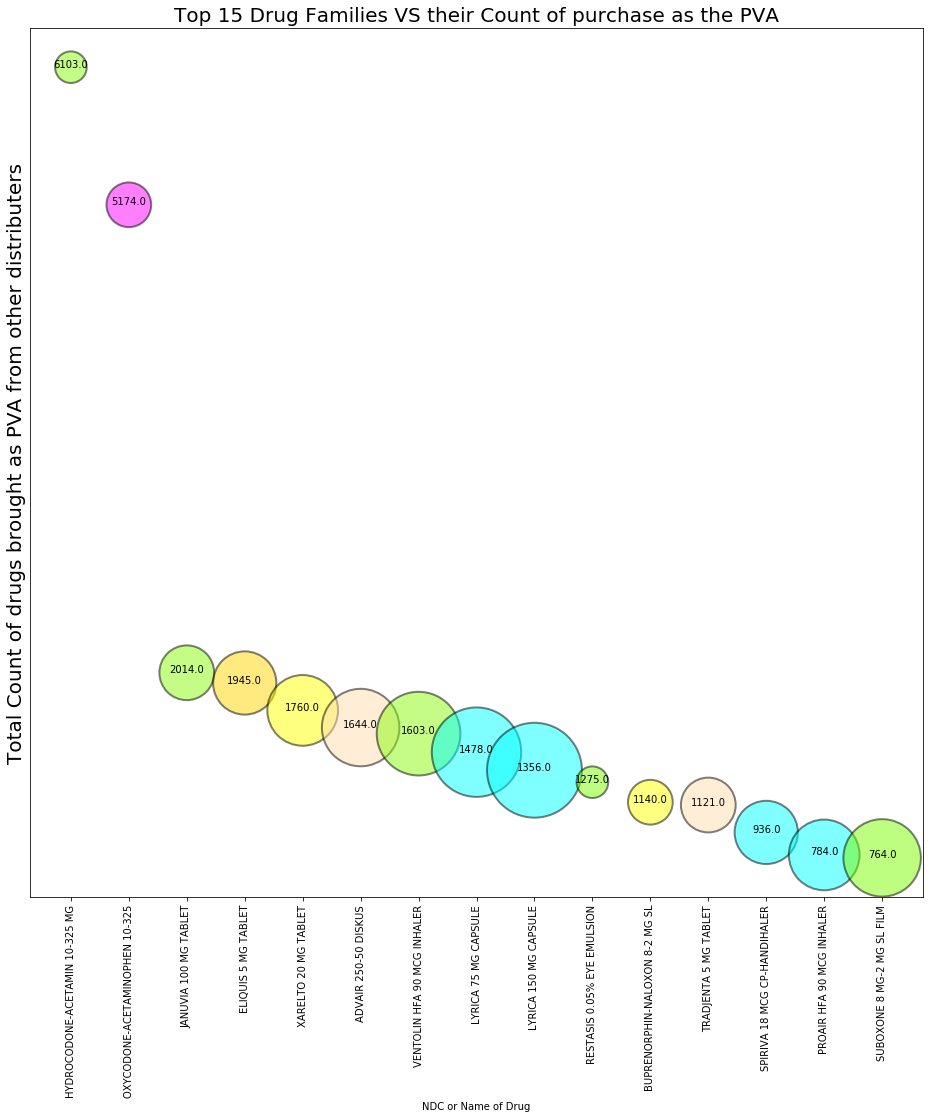

In [317]:
def visual2():
    overAllPVA= func1()
    overAllPVA.sort_values(by=['Total Count of Drug Being PVA for Pharmacies'],ascending=False,inplace=True)
    #display(overAllPVA)    
    color=np.arange(1,10,1)
    ax = plt.figure(figsize=(16,16))

    ax=plt.scatter(x=overAllPVA['Name of The drug'][0:15],y=overAllPVA['Total Count of Drug Being PVA for Pharmacies'][0:15],
                c=['#8BFA0D','#FF00FF','#8BFA0D','#FFD700','#FFFF00','#FFDEAD','#8BFA0D','#00FFFF','#00FFFF',
                 '#7CFC00','#FFFF00','#FFDEAD','#00FFFF','#00FFFF',
                 '#7CFC00'],s=color*1000,alpha=0.50,edgecolors='black',linewidth=2)
    #plt.legend(loc='best')
    plt.tick_params(labelleft=False,left=False)
    plt.xticks(rotation=90)
    #plt.box(False)
    plt.ylabel('Total Count of drugs brought as PVA from other distributers',fontsize=20 )
    plt.xlabel('NDC or Name of Drug')
    plt.title('Top 15 Drug Families VS their Count of purchase as the PVA',fontsize=20)
    for i, value in enumerate(overAllPVA['Total Count of Drug Being PVA for Pharmacies'][0:15]):
        #plt.text(i-0.15,value,str(value),color='Black',fontsize=10)
        plt.annotate(str(value),xy=(i,value),ha='center')
    plt.show()   
visual2()
         

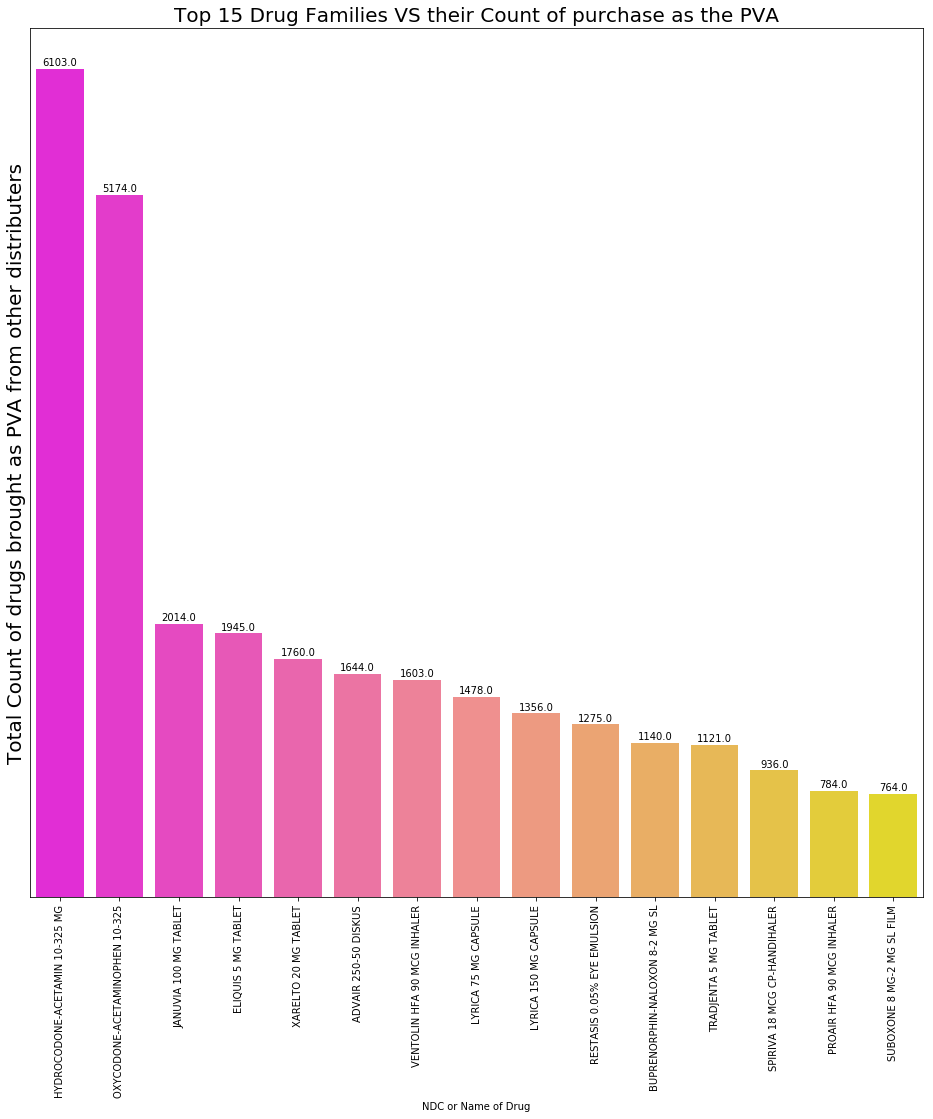

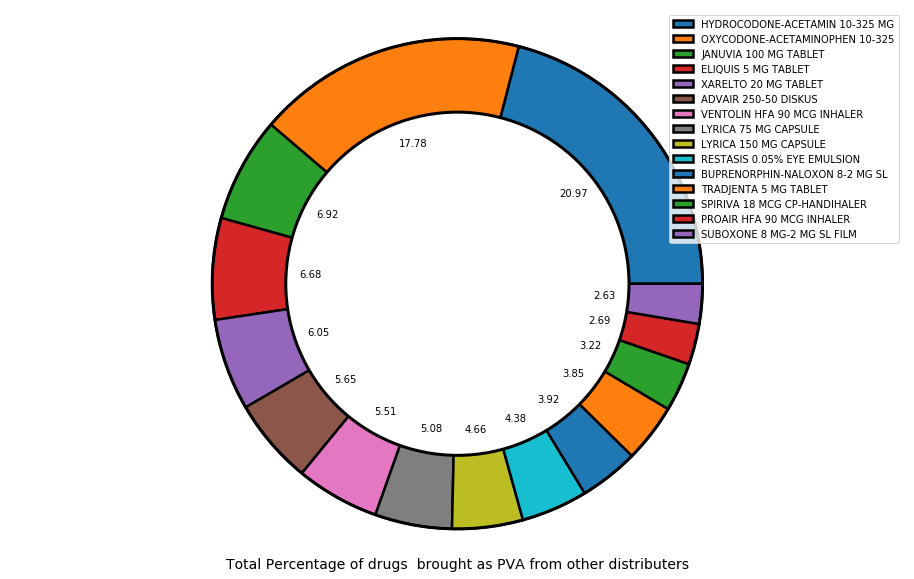

In [344]:
def visual2():
    overAllPVA= func1()
    overAllPVA.sort_values(by=['Total Count of Drug Being PVA for Pharmacies'],ascending=False,inplace=True)
    #display(overAllPVA)    
    color=np.arange(1,10,1)
    ax = plt.figure(figsize=(16,16))

    ax=sns.barplot(x=overAllPVA['Name of The drug'][0:15],y=overAllPVA['Total Count of Drug Being PVA for Pharmacies'][0:15],
                    palette='spring')
    #plt.legend(loc='best')
    plt.tick_params(labelleft=False,left=False)
    plt.xticks(rotation=90)
    #plt.box(False)
    plt.ylabel('Total Count of drugs brought as PVA from other distributers',fontsize=20 )
    plt.xlabel('NDC or Name of Drug')
    plt.title('Top 15 Drug Families VS their Count of purchase as the PVA',fontsize=20)
    for i, value in enumerate(overAllPVA['Total Count of Drug Being PVA for Pharmacies'][0:15]):
        #plt.text(i-0.15,value,str(value),color='Black',fontsize=10)
        plt.annotate(str(value),xy=(i,value+25),ha='center')
    plt.show()
    plt.figure(figsize=(16,10))
    plt.pie(x=overAllPVA['Total Count of Drug Being PVA for Pharmacies'][0:15],autopct='%.2f',wedgeprops={'linewidth':2.5,'edgecolor':'black'})
    C=plt.Circle((0,0),0.70,fc='white',color='black',linewidth=3.0)
    COutside=plt.Circle((0,0),1,fill=False,edgecolor='black',linewidth=3.0)
    f=plt.gcf()
    f.gca().add_artist(C)
    f.gca().add_patch(COutside)
    plt.axis('equal')
    plt.legend(labels=overAllPVA['Name of The drug'][0:15],loc='best')
    plt.xlabel('Total Percentage of drugs  brought as PVA from other distributers',fontsize=14)
    plt.show()
visual2()
         

,Name of The drug,Total Count of Drug Being PVA for Pharmacies,Total Count of Drug Being Non-PVA for Phramacies
0,SYMBICORT 160-4.5 MCG INHALER,561.0,2680.0
1,PROVENTIL HFA 90 MCG INHALER,268.0,2592.0
2,VICTOZA 3-PAK 18 MG/3 ML PEN,145.0,2108.0
3,TRULICITY 1.5 MG/0.5 ML PEN,5.0,2089.0
4,HUMALOG 100 UNITS/ML KWIKPEN,382.0,2037.0
5,BASAGLAR 100 UNIT/ML KWIKPEN,445.0,1999.0
6,LANTUS SOLOSTAR 100 UNIT/ML,693.0,1943.0
7,HUMALOG 100 UNITS/ML VIAL,362.0,1928.0
8,NOVOLOG 100 UNITS/ML FLEXPEN,521.0,1920.0
9,PROAIR HFA 90 MCG INHALER,784.0,1904.0


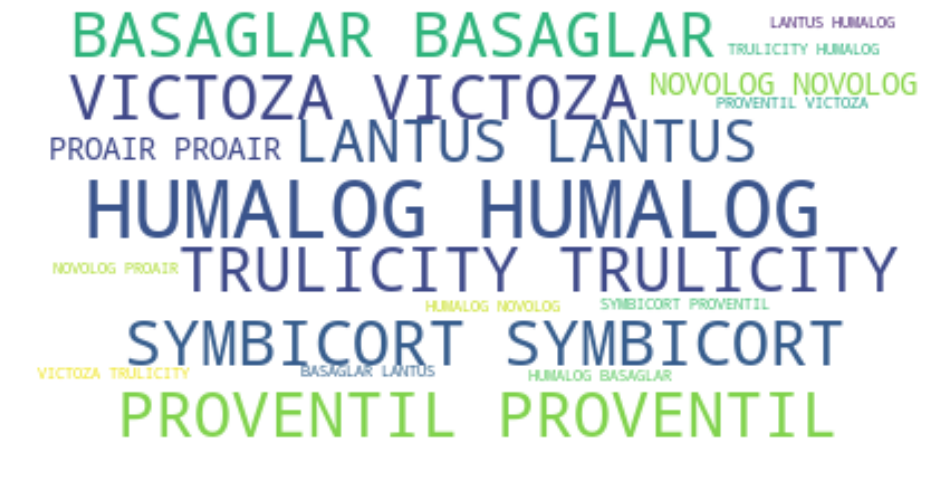

In [374]:
def wordCloud():
    from wordcloud import WordCloud,STOPWORDS
    sw=set(STOPWORDS)
    overAllPVA= func1()
    overAllPVA.sort_values(by=['Total Count of Drug Being Non-PVA for Phramacies'],ascending=False,inplace=True)
    overAllPVA.reset_index(drop=True,inplace=True)
    display(overAllPVA[0:10])
    x=overAllPVA['Name of The drug'][0:10]
    y=overAllPVA['Total Count of Drug Being Non-PVA for Phramacies'][0:10]
    listOfWords=''
    for each in x:
        each=each.split(' ')[0]
        k=0
        for elem in y:
            while k < elem:
                if listOfWords == ''  :
                    listOfWords = each
                else:
                    listOfWords = listOfWords + ' ' + each
                k+=1
    wcObj = WordCloud(background_color='white',max_words=len(listOfWords),stopwords=sw)
    wcObj.generate(listOfWords)
    fig=plt.figure()
    fig.set_figwidth(16)
    fig.set_figheight(16)
    plt.imshow(wcObj,interpolation='bilinear')
    plt.axis('off')
    plt.show()
wordCloud()

In [453]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
df=pd.read_csv('AIS datasheet.csv')
df=df[['PHRMCY_NAME','NDC_DESC','DSPN_COGS_NDC_1WK','DSPN_COGS_NDC_4WKS','DSPN_COGS_NDC_13WKS','DSPN_COGS_NDC_26WKS']]
overAllDTFrame=pd.DataFrame()
for key,value in df.groupby('PHRMCY_NAME'):
    value.reset_index(drop=True,inplace=True)
   
    listOfCols=['DSPN_COGS_NDC_1WK','DSPN_COGS_NDC_4WKS','DSPN_COGS_NDC_13WKS','DSPN_COGS_NDC_26WKS']
    for i in range(0,len(listOfCols),4):
        #print(value[listOfCols[i+1]],value[listOfCols[i]])
        value[listOfCols[i+1]+ '-'+listOfCols[i]]=value.loc[:,listOfCols[i+1]]-value.loc[:,listOfCols[i]]
        value[listOfCols[i+2]+ '-'+listOfCols[i+1]]=value[listOfCols[i+2]]-value[listOfCols[i+1]]
        value[listOfCols[i+3]+ '-'+listOfCols[i+2]]=value[listOfCols[i+3]]-value[listOfCols[i+2]]
        #break
    elem=pd.DataFrame([value[(value['DSPN_COGS_NDC_4WKS-DSPN_COGS_NDC_1WK'] > 0) & (value['DSPN_COGS_NDC_13WKS-DSPN_COGS_NDC_4WKS'] > 0)
                 & (value['DSPN_COGS_NDC_26WKS-DSPN_COGS_NDC_13WKS']) > 0].shape[0]])
    keyDTFrame=pd.concat([pd.DataFrame([key]),elem,pd.DataFrame([value.shape[0]])],axis=1)
    overAllDTFrame=pd.concat([overAllDTFrame,keyDTFrame],axis=0)
    #display(pd.DataFrame([key]))
    #display(value[(value['DSPN_COGS_NDC_4WKS-DSPN_COGS_NDC_1WK'] > 0) & (value['DSPN_COGS_NDC_13WKS-DSPN_COGS_NDC_4WKS'] > 0)
                 #& (value['DSPN_COGS_NDC_26WKS-DSPN_COGS_NDC_13WKS'] > 0)].shape)
    #display(value.shape)
overAllDTFrame.columns=['PHARMACY Name','Total No of potential PVA among NDCs in the PHARMACY group','Total No of NDCs in the PHARMACY group']
overAllDTFrame.reset_index(drop=True,inplace=True)
display(overAllDTFrame)
    


C:\Users\supratik chanda\Documents\New folder (2)\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Users\supratik chanda\Documents\New folder (2)\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
C:\Users\supratik chanda\Documents\New folder (2)\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

,PHARMACY Name,Total No of potential PVA among NDCs in the PHARMACY group,Total No of NDCs in the PHARMACY group
0,PHARMACY 1,24,39
1,PHARMACY 10,22,28
2,PHARMACY 100,34,58
3,PHARMACY 1000,17,35
4,PHARMACY 1001,0,36
5,PHARMACY 1002,35,44
6,PHARMACY 1003,21,31
7,PHARMACY 1004,21,34
8,PHARMACY 1005,11,21
9,PHARMACY 1006,36,43


In [486]:
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
df= pd.read_csv('AIS datasheet.csv',usecols=['PHRMCY_NAME','NDC_DESC','PURCH_QTY_NDC_1WK_MTRC','DSPN_COGS_NDC_1WK','COGS_PRC_MTRC'])
df['DSPN_COGS_NDC_1WK'] = df['DSPN_COGS_NDC_1WK'].div(df['COGS_PRC_MTRC'],axis=0)
df['DIff_BTWN_PURCH_DSPN']=round((df['PURCH_QTY_NDC_1WK_MTRC']-df['DSPN_COGS_NDC_1WK']),4)
df = df.fillna(0)
#display(df)
k=0
for key,value in df.groupby('NDC_DESC'):
    display(value)
    k+=1
    if k == 20:
        break

,PHRMCY_NAME,NDC_DESC,PURCH_QTY_NDC_1WK_MTRC,COGS_PRC_MTRC,DSPN_COGS_NDC_1WK,DIff_BTWN_PURCH_DSPN
21134,PHARMACY 536,"""ADVATE 1,801-2,400 UNIT VIAL""",0.0,2368.5400,0.0,0.0
52928,PHARMACY 2393,"""ADVATE 1,801-2,400 UNIT VIAL""",0.0,1.5484,24162.0,-24162.0
76856,PHARMACY 2252,"""ADVATE 1,801-2,400 UNIT VIAL""",0.0,1.5484,0.0,0.0


,PHRMCY_NAME,NDC_DESC,PURCH_QTY_NDC_1WK_MTRC,COGS_PRC_MTRC,DSPN_COGS_NDC_1WK,DIff_BTWN_PURCH_DSPN
52933,PHARMACY 2393,"""ADVATE 801-1,200 UNIT VIAL""",0.0,1.5484,0.0,0.0
76859,PHARMACY 2252,"""ADVATE 801-1,200 UNIT VIAL""",0.0,1.5484,0.0,0.0


,PHRMCY_NAME,NDC_DESC,PURCH_QTY_NDC_1WK_MTRC,COGS_PRC_MTRC,DSPN_COGS_NDC_1WK,DIff_BTWN_PURCH_DSPN
63182,PHARMACY 1793,"""ADYNOVATE 1,500 UNIT VIAL""",8.0,2446.67,12104.0,-12096.0


,PHRMCY_NAME,NDC_DESC,PURCH_QTY_NDC_1WK_MTRC,COGS_PRC_MTRC,DSPN_COGS_NDC_1WK,DIff_BTWN_PURCH_DSPN
88387,PHARMACY 2644,"""HELIXATE FS 1,000 UNIT VIAL""",0.0,967.5,0.0,0.0


,PHRMCY_NAME,NDC_DESC,PURCH_QTY_NDC_1WK_MTRC,COGS_PRC_MTRC,DSPN_COGS_NDC_1WK,DIff_BTWN_PURCH_DSPN
52926,PHARMACY 2393,"""HELIXATE FS 2,000 UNIT VIAL""",0.0,1.4406,0.0,0.0


,PHRMCY_NAME,NDC_DESC,PURCH_QTY_NDC_1WK_MTRC,COGS_PRC_MTRC,DSPN_COGS_NDC_1WK,DIff_BTWN_PURCH_DSPN
52905,PHARMACY 2393,"""KOGENATE FS 1,000 UNITS VIAL""",0.0,1.5484,0.0,0.0
88384,PHARMACY 2644,"""KOGENATE FS 1,000 UNITS VIAL""",0.0,1.5484,0.0,0.0


,PHRMCY_NAME,NDC_DESC,PURCH_QTY_NDC_1WK_MTRC,COGS_PRC_MTRC,DSPN_COGS_NDC_1WK,DIff_BTWN_PURCH_DSPN
52944,PHARMACY 2393,"""KOGENATE FS 2,000 UNIT VIAL""",0.0,1.5484,0.0,0.0
63174,PHARMACY 1793,"""KOGENATE FS 2,000 UNIT VIAL""",0.0,433.6300,21660.0,-21660.0
76870,PHARMACY 2252,"""KOGENATE FS 2,000 UNIT VIAL""",0.0,1.5484,0.0,0.0
88389,PHARMACY 2644,"""KOGENATE FS 2,000 UNIT VIAL""",0.0,1.5484,0.0,0.0


,PHRMCY_NAME,NDC_DESC,PURCH_QTY_NDC_1WK_MTRC,COGS_PRC_MTRC,DSPN_COGS_NDC_1WK,DIff_BTWN_PURCH_DSPN
52914,PHARMACY 2393,"""KOVALTRY 2,000 UNIT KIT""",0.0,1.7052,25116.0,-25116.0
88385,PHARMACY 2644,"""KOVALTRY 2,000 UNIT KIT""",0.0,1.2282,0.0,0.0


,PHRMCY_NAME,NDC_DESC,PURCH_QTY_NDC_1WK_MTRC,COGS_PRC_MTRC,DSPN_COGS_NDC_1WK,DIff_BTWN_PURCH_DSPN
227,PHARMACY 559,ADMELOG 100 UNIT/ML VIAL,0.0,22.487,10.000000,-10.0000
397,PHARMACY 765,ADMELOG 100 UNIT/ML VIAL,10.0,0.000,0.000000,0.0000
718,PHARMACY 42,ADMELOG 100 UNIT/ML VIAL,0.0,22.883,0.000000,0.0000
901,PHARMACY 79,ADMELOG 100 UNIT/ML VIAL,10.0,22.253,0.000000,10.0000
1317,PHARMACY 238,ADMELOG 100 UNIT/ML VIAL,0.0,22.883,0.000000,0.0000
1725,PHARMACY 394,ADMELOG 100 UNIT/ML VIAL,0.0,22.365,0.000000,0.0000
2185,PHARMACY 541,ADMELOG 100 UNIT/ML VIAL,0.0,22.365,0.000000,0.0000
2286,PHARMACY 558,ADMELOG 100 UNIT/ML VIAL,0.0,22.883,0.000000,0.0000
2454,PHARMACY 597,ADMELOG 100 UNIT/ML VIAL,10.0,22.276,10.000000,0.0000
2704,PHARMACY 707,ADMELOG 100 UNIT/ML VIAL,30.0,22.883,20.000000,10.0000


,PHRMCY_NAME,NDC_DESC,PURCH_QTY_NDC_1WK_MTRC,COGS_PRC_MTRC,DSPN_COGS_NDC_1WK,DIff_BTWN_PURCH_DSPN
188,PHARMACY 430,ADMELOG SOLOSTAR 100 UNIT/ML,15.0,28.5387,14.999986,0.0
211,PHARMACY 559,ADMELOG SOLOSTAR 100 UNIT/ML,0.0,28.9440,0.000000,0.0
296,PHARMACY 598,ADMELOG SOLOSTAR 100 UNIT/ML,0.0,29.4549,0.000000,0.0
352,PHARMACY 653,ADMELOG SOLOSTAR 100 UNIT/ML,15.0,28.7880,0.000000,15.0
693,PHARMACY 42,ADMELOG SOLOSTAR 100 UNIT/ML,15.0,28.7787,0.000000,15.0
742,PHARMACY 50,ADMELOG SOLOSTAR 100 UNIT/ML,0.0,28.7487,0.000000,0.0
831,PHARMACY 53,ADMELOG SOLOSTAR 100 UNIT/ML,0.0,29.4549,29.999980,-30.0
878,PHARMACY 73,ADMELOG SOLOSTAR 100 UNIT/ML,15.0,29.4549,14.999990,0.0
1176,PHARMACY 208,ADMELOG SOLOSTAR 100 UNIT/ML,0.0,29.4549,0.000000,0.0
1739,PHARMACY 394,ADMELOG SOLOSTAR 100 UNIT/ML,0.0,0.0000,0.000000,0.0


,PHRMCY_NAME,NDC_DESC,PURCH_QTY_NDC_1WK_MTRC,COGS_PRC_MTRC,DSPN_COGS_NDC_1WK,DIff_BTWN_PURCH_DSPN
1,PHARMACY 1126,ADVAIR 250-50 DISKUS,0.0,6.4342,239.999627,-239.9996
38,PHARMACY 1448,ADVAIR 250-50 DISKUS,300.0,6.2865,0.000000,300.0000
102,PHARMACY 145,ADVAIR 250-50 DISKUS,0.0,6.2668,60.000287,-60.0003
117,PHARMACY 165,ADVAIR 250-50 DISKUS,60.0,6.2505,0.000000,60.0000
145,PHARMACY 319,ADVAIR 250-50 DISKUS,0.0,6.2865,0.000000,0.0000
173,PHARMACY 430,ADVAIR 250-50 DISKUS,0.0,6.2340,0.000000,0.0000
226,PHARMACY 559,ADVAIR 250-50 DISKUS,60.0,6.3227,0.000000,60.0000
238,PHARMACY 581,ADVAIR 250-50 DISKUS,60.0,6.2932,59.999714,0.0003
279,PHARMACY 598,ADVAIR 250-50 DISKUS,60.0,6.2373,0.000000,60.0000
309,PHARMACY 620,ADVAIR 250-50 DISKUS,60.0,6.2800,60.000000,0.0000


,PHRMCY_NAME,NDC_DESC,PURCH_QTY_NDC_1WK_MTRC,COGS_PRC_MTRC,DSPN_COGS_NDC_1WK,DIff_BTWN_PURCH_DSPN
52911,PHARMACY 2393,ADVATE 401-800 UNIT VIAL,0.0,1.5484,1116.0,-1116.0


,PHRMCY_NAME,NDC_DESC,PURCH_QTY_NDC_1WK_MTRC,COGS_PRC_MTRC,DSPN_COGS_NDC_1WK,DIff_BTWN_PURCH_DSPN
31,PHARMACY 1126,BASAGLAR 100 UNIT/ML KWIKPEN,0.0,21.3222,0.000000,0.0000
73,PHARMACY 1448,BASAGLAR 100 UNIT/ML KWIKPEN,15.0,21.2140,0.000000,15.0000
97,PHARMACY 145,BASAGLAR 100 UNIT/ML KWIKPEN,180.0,21.1047,44.999938,135.0001
110,PHARMACY 165,BASAGLAR 100 UNIT/ML KWIKPEN,0.0,21.1047,14.999981,-15.0000
165,PHARMACY 319,BASAGLAR 100 UNIT/ML KWIKPEN,0.0,21.3222,0.000000,0.0000
202,PHARMACY 430,BASAGLAR 100 UNIT/ML KWIKPEN,45.0,21.1047,74.999900,-29.9999
220,PHARMACY 559,BASAGLAR 100 UNIT/ML KWIKPEN,45.0,21.1047,44.999943,0.0001
263,PHARMACY 581,BASAGLAR 100 UNIT/ML KWIKPEN,30.0,21.1047,29.999962,0.0000
274,PHARMACY 598,BASAGLAR 100 UNIT/ML KWIKPEN,15.0,21.2140,0.000000,15.0000
342,PHARMACY 620,BASAGLAR 100 UNIT/ML KWIKPEN,15.0,21.1047,29.999962,-15.0000


,PHRMCY_NAME,NDC_DESC,PURCH_QTY_NDC_1WK_MTRC,COGS_PRC_MTRC,DSPN_COGS_NDC_1WK,DIff_BTWN_PURCH_DSPN
988,PHARMACY 82,BIKTARVY 50-200-25 MG TABLET,0.0,95.7337,0.000000,0.0000
1015,PHARMACY 117,BIKTARVY 50-200-25 MG TABLET,0.0,96.2246,0.000000,0.0000
1550,PHARMACY 350,BIKTARVY 50-200-25 MG TABLET,0.0,95.7337,0.000000,0.0000
1605,PHARMACY 365,BIKTARVY 50-200-25 MG TABLET,0.0,93.6227,0.000000,0.0000
1675,PHARMACY 375,BIKTARVY 50-200-25 MG TABLET,30.0,96.2246,29.999989,0.0000
1701,PHARMACY 389,BIKTARVY 50-200-25 MG TABLET,30.0,94.1137,29.999990,0.0000
2227,PHARMACY 554,BIKTARVY 50-200-25 MG TABLET,0.0,95.7337,29.999991,-30.0000
2328,PHARMACY 568,BIKTARVY 50-200-25 MG TABLET,0.0,95.7337,0.000000,0.0000
2700,PHARMACY 707,BIKTARVY 50-200-25 MG TABLET,0.0,96.2247,149.999953,-150.0000
3462,PHARMACY 873,BIKTARVY 50-200-25 MG TABLET,0.0,95.7337,0.000000,0.0000


,PHRMCY_NAME,NDC_DESC,PURCH_QTY_NDC_1WK_MTRC,COGS_PRC_MTRC,DSPN_COGS_NDC_1WK,DIff_BTWN_PURCH_DSPN
76,PHARMACY 1448,BUPRENORP-NALOX 8-2 MG SL FILM,0.0,5.4610,0.000000,0.0000
93,PHARMACY 145,BUPRENORP-NALOX 8-2 MG SL FILM,0.0,6.3330,0.000000,0.0000
141,PHARMACY 165,BUPRENORP-NALOX 8-2 MG SL FILM,0.0,6.3330,0.000000,0.0000
199,PHARMACY 430,BUPRENORP-NALOX 8-2 MG SL FILM,0.0,6.3330,0.000000,0.0000
337,PHARMACY 620,BUPRENORP-NALOX 8-2 MG SL FILM,0.0,6.3330,0.000000,0.0000
529,PHARMACY 835,BUPRENORP-NALOX 8-2 MG SL FILM,0.0,5.8263,0.000000,0.0000
626,PHARMACY 1,BUPRENORP-NALOX 8-2 MG SL FILM,0.0,6.3330,0.000000,0.0000
707,PHARMACY 42,BUPRENORP-NALOX 8-2 MG SL FILM,0.0,6.3330,0.000000,0.0000
754,PHARMACY 50,BUPRENORP-NALOX 8-2 MG SL FILM,0.0,6.3330,28.000000,-28.0000
778,PHARMACY 51,BUPRENORP-NALOX 8-2 MG SL FILM,0.0,6.3330,0.000000,0.0000


,PHRMCY_NAME,NDC_DESC,PURCH_QTY_NDC_1WK_MTRC,COGS_PRC_MTRC,DSPN_COGS_NDC_1WK,DIff_BTWN_PURCH_DSPN
23,PHARMACY 1126,BUPRENORPHIN-NALOXON 8-2 MG SL,0.0,3.6100,14.000000,-14.0000
24,PHARMACY 1126,BUPRENORPHIN-NALOXON 8-2 MG SL,0.0,3.3573,0.000000,0.0000
61,PHARMACY 1448,BUPRENORPHIN-NALOXON 8-2 MG SL,0.0,3.4297,0.000000,0.0000
65,PHARMACY 1448,BUPRENORPHIN-NALOXON 8-2 MG SL,0.0,3.4297,0.000000,0.0000
70,PHARMACY 1448,BUPRENORPHIN-NALOXON 8-2 MG SL,0.0,0.0000,0.000000,0.0000
193,PHARMACY 430,BUPRENORPHIN-NALOXON 8-2 MG SL,30.0,3.6100,18.000000,12.0000
194,PHARMACY 430,BUPRENORPHIN-NALOXON 8-2 MG SL,0.0,3.6100,0.000000,0.0000
215,PHARMACY 559,BUPRENORPHIN-NALOXON 8-2 MG SL,0.0,3.6100,0.000000,0.0000
291,PHARMACY 598,BUPRENORPHIN-NALOXON 8-2 MG SL,0.0,3.3573,0.000000,0.0000
301,PHARMACY 598,BUPRENORPHIN-NALOXON 8-2 MG SL,0.0,3.3573,191.000000,-191.0000


,PHRMCY_NAME,NDC_DESC,PURCH_QTY_NDC_1WK_MTRC,COGS_PRC_MTRC,DSPN_COGS_NDC_1WK,DIff_BTWN_PURCH_DSPN
60,PHARMACY 1448,DESCOVY 200-25 MG TABLET,0.0,54.7425,0.000000,0.0000
378,PHARMACY 765,DESCOVY 200-25 MG TABLET,30.0,54.4633,0.000000,30.0000
425,PHARMACY 767,DESCOVY 200-25 MG TABLET,30.0,54.4633,30.000017,-0.0000
488,PHARMACY 827,DESCOVY 200-25 MG TABLET,0.0,54.4633,0.000000,0.0000
748,PHARMACY 50,DESCOVY 200-25 MG TABLET,0.0,54.4633,0.000000,0.0000
1008,PHARMACY 82,DESCOVY 200-25 MG TABLET,90.0,54.4633,120.000066,-30.0001
1029,PHARMACY 117,DESCOVY 200-25 MG TABLET,0.0,54.4633,0.000000,0.0000
1184,PHARMACY 208,DESCOVY 200-25 MG TABLET,0.0,54.4633,0.000000,0.0000
1458,PHARMACY 296,DESCOVY 200-25 MG TABLET,0.0,54.7427,0.000000,0.0000
1630,PHARMACY 365,DESCOVY 200-25 MG TABLET,60.0,54.4633,30.000017,30.0000


,PHRMCY_NAME,NDC_DESC,PURCH_QTY_NDC_1WK_MTRC,COGS_PRC_MTRC,DSPN_COGS_NDC_1WK,DIff_BTWN_PURCH_DSPN
399,PHARMACY 765,DUEXIS 800-26.6 MG TABLET,0.0,26.2010,0.000000,0.0000
604,PHARMACY 1,DUEXIS 800-26.6 MG TABLET,0.0,26.5596,0.000000,0.0000
849,PHARMACY 54,DUEXIS 800-26.6 MG TABLET,0.0,27.0284,0.000000,0.0000
903,PHARMACY 79,DUEXIS 800-26.6 MG TABLET,0.0,26.2838,0.000000,0.0000
1110,PHARMACY 195,DUEXIS 800-26.6 MG TABLET,0.0,26.0631,0.000000,0.0000
1397,PHARMACY 282,DUEXIS 800-26.6 MG TABLET,1350.0,26.0631,750.000288,599.9997
1407,PHARMACY 287,DUEXIS 800-26.6 MG TABLET,0.0,26.5320,0.000000,0.0000
1514,PHARMACY 347,DUEXIS 800-26.6 MG TABLET,0.0,26.4410,0.000000,0.0000
1608,PHARMACY 365,DUEXIS 800-26.6 MG TABLET,720.0,26.2976,1949.997034,-1229.9970
2069,PHARMACY 469,DUEXIS 800-26.6 MG TABLET,0.0,27.0284,0.000000,0.0000


,PHRMCY_NAME,NDC_DESC,PURCH_QTY_NDC_1WK_MTRC,COGS_PRC_MTRC,DSPN_COGS_NDC_1WK,DIff_BTWN_PURCH_DSPN
13,PHARMACY 1126,ELIQUIS 5 MG TABLET,0.0,6.8442,0.000000,0.0000
54,PHARMACY 1448,ELIQUIS 5 MG TABLET,420.0,6.6872,119.999462,300.0005
82,PHARMACY 145,ELIQUIS 5 MG TABLET,480.0,6.6662,479.997840,0.0022
107,PHARMACY 165,ELIQUIS 5 MG TABLET,0.0,6.8442,0.000000,0.0000
126,PHARMACY 165,ELIQUIS 5 MG TABLET,0.0,6.6487,0.000000,0.0000
152,PHARMACY 319,ELIQUIS 5 MG TABLET,60.0,6.6872,59.999731,0.0003
185,PHARMACY 430,ELIQUIS 5 MG TABLET,360.0,6.6312,329.998507,30.0015
207,PHARMACY 559,ELIQUIS 5 MG TABLET,0.0,6.7255,0.000000,0.0000
250,PHARMACY 581,ELIQUIS 5 MG TABLET,180.0,6.6942,179.999193,0.0008
271,PHARMACY 598,ELIQUIS 5 MG TABLET,0.0,6.8442,0.000000,0.0000


,PHRMCY_NAME,NDC_DESC,PURCH_QTY_NDC_1WK_MTRC,COGS_PRC_MTRC,DSPN_COGS_NDC_1WK,DIff_BTWN_PURCH_DSPN
19,PHARMACY 1126,ENBREL 50 MG/ML SURECLICK SYR,0.00,1218.0000,11.760000,-11.76
88,PHARMACY 145,ENBREL 50 MG/ML SURECLICK SYR,0.00,1211.7857,0.000000,0.00
955,PHARMACY 80,ENBREL 50 MG/ML SURECLICK SYR,0.00,1211.7857,0.000000,0.00
1009,PHARMACY 82,ENBREL 50 MG/ML SURECLICK SYR,3.92,1216.7577,3.920000,0.00
1027,PHARMACY 117,ENBREL 50 MG/ML SURECLICK SYR,3.92,1218.0000,3.920000,-0.00
1092,PHARMACY 132,ENBREL 50 MG/ML SURECLICK SYR,0.00,1218.0000,0.000000,0.00
1236,PHARMACY 211,ENBREL 50 MG/ML SURECLICK SYR,0.00,1218.0000,0.000000,0.00
1364,PHARMACY 272,ENBREL 50 MG/ML SURECLICK SYR,3.92,1218.0000,3.920000,-0.00
1408,PHARMACY 287,ENBREL 50 MG/ML SURECLICK SYR,0.00,1211.7857,0.000000,0.00
1533,PHARMACY 347,ENBREL 50 MG/ML SURECLICK SYR,0.00,1218.0000,0.000000,0.00
